# Install Packages and import libraries

In [ ]:
# install spacy
!python -m spacy download en_core_web_lg

2023-06-23 07:59:59.414660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 08:00:00.950966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=28541ee87d910e03cfdd37779eed7ef96b70b32c154ea1e19d6c9e11542d65db
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
# for data manipulation
import pandas as pd
import numpy as np
import os

# for scoring
import spacy
from collections import Counter

# for statistical analysis
import pingouin as pg
from scipy.stats import shapiro, levene, permutation_test
from statsmodels.stats.multitest import multipletests

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for analysis

Load your dataset: "DecOp_data_EN_500.csv"

In [ ]:
data = pd.read_excel('/content/DecOp_data_EN_500.xlsx')
data.head()

,ID,gender,age,A,GT.A,CL,GT.CL,E,GT.E,GM,GT.GM,Pom,GT.Pom
0,1,F,28,Abortion should be banned! People are killing ...,F,I think it should be legalized and regulated l...,T,I'm assuming we're talking about animals... eu...,T,I think gay marriage is just a normal as strai...,T,We need to keep them out of the country. They ...,F
1,2,F,59,I believe in a woman's right to choose to abor...,F,I am for cannabis legalization for medicinal p...,T,I don't believe in taking one's own life.\nOnl...,T,I am against gay marriage. \nThe Bible is my g...,T,We should allow all migrants in to this countr...,F
2,3,F,48,i am for abortion. I believe that women have t...,F,I don't believe that cannabis should be legal....,T,I am not for euthanasia for people or animals....,T,I do not believe that gay marriage should be a...,T,i believe in open borders. America is founded ...,F
3,4,M,20,Abortion is so terrible! I don't understand wh...,F,"People smoke weed all the time, and the war on...",T,"If someone was suffering and wanted to die, th...",T,"Gay Marriage is okay. I am not against it, and...",T,Migrants are taking all of our jobs! We do not...,F
4,5,F,37,I think it should not be a womans choice wheth...,F,Why not start having to pay tax on it and regu...,T,I think this is awful. Only God can decide whe...,T,I think gay marriage is a great thing. No one ...,T,Migrants should be welcome with no government ...,F


In [ ]:
data.shape

(500, 13)

In [ ]:
df = []
for i in range(data.shape[0]):
    row = data.iloc[i]
    df.append({'ID': row['ID'],
        'age' :row['age'], 'gender': row['gender'],
    'sent' : row['A'].replace('\n', " ") ,
    'labels'  : row['GT.A'],
    'topic': 'Abortion'})

    df.append({'ID': row['ID'],
        'age' :row['age'], 'gender': row['gender'],
    'sent' : row['E'].replace('\n', " ")  ,
    'labels'  : row['GT.E'],
    'topic': 'Euthanasia'})

    df.append({'ID': row['ID'],
        'age' :row['age'], 'gender': row['gender'],
    'sent' : row['GM'].replace('\n', " ")  ,
    'labels'  : row['GT.GM'],
    'topic': 'Gay Marriage'})

    df.append({'ID': row['ID'],
        'age' :row['age'], 'gender': row['gender'],
    'sent' : row['Pom'].replace('\n', " ")  ,
    'labels'  : row['GT.Pom'],
    'topic': 'Migration'})

    df.append({'ID': row['ID'],
        'age' :row['age'], 'gender': row['gender'],
    'sent' : row['CL'].replace('\n', " ")  ,
    'labels'  : row['GT.CL'],
    'topic': 'Cannabis Legalization'})

df = pd.DataFrame.from_records(df)


In [ ]:
df = pd.DataFrame.from_records(df)
df.head()

,ID,age,gender,sent,labels,topic
0,1,28,F,Abortion should be banned! People are killing ...,F,Abortion
1,1,28,F,I'm assuming we're talking about animals... eu...,T,Euthanasia
2,1,28,F,I think gay marriage is just a normal as strai...,T,Gay Marriage
3,1,28,F,We need to keep them out of the country. They ...,F,Migration
4,1,28,F,I think it should be legalized and regulated l...,T,Cannabis Legalization


In [ ]:
df.shape

(2500, 6)

In [ ]:
df['sent'][0]

'Abortion should be banned! People are killing babies! If you have sex, you have to live with the consequences!'

In [ ]:
df['sent'][1]

"I'm assuming we're talking about animals... euthanasia makes me sad, but i understand that it has become necessary with the domesticated animal overpopulation problem. It humanely eliminates animals that would contribute to the problem."

In [ ]:
df.isna().sum()

ID        0
age       0
gender    0
sent      0
labels    0
topic     0
dtype: int64

# Text Preprocessing

**Preprocessing steps:**

Compute tokenization and remove punctuations and extra spaces to count the exact number of words.

In [ ]:
# Load Spacy's English language model
nlp = spacy.load("en_core_web_lg")

In [ ]:
docs = []

for doc in nlp.pipe(df['sent'], n_process=os.cpu_count()-1, disable = ['transformer']):
    docs.append(doc)

In [ ]:
# Define a function to tokenize text
def tokenize(doc):

    # Remove punctuation and double space:
    tokens = [token.text for token in doc if not (token.is_punct or token.is_space)]
    # Join tokens back into a string
    tokens = " ".join(tokens)
    return tokens.lower()

In [ ]:
# Apply the preprocessing pipeline using nlp.pipe
tokens = []

for doc in docs:
    tokens.append(tokenize(doc))

# Add the preprocessed text as a new column in the dataframe
df['tokens'] = tokens

In [ ]:
df['tokens'][0]

'abortion should be banned people are killing babies if you have sex you have to live with the consequences'

In [ ]:
# Define a function to lemmatize content words
def preprocessed_text(doc):
    # Remove punctuation, double space, stop words and lemmatize text:
    clean_tokens = [token.lemma_ for token in doc if not (token.is_punct or token.is_space or token.is_stop)]
    # Join the cleaned tokens back into a string
    clean_text = " ".join(clean_tokens)
    return clean_text.lower()

In [ ]:
# Apply the preprocessing pipeline using nlp.pipe
clean_text = []

for doc in docs:
    clean_text.append(preprocessed_text(doc))

# Add the preprocessed text as a new column in the dataframe
df['clean_text'] = clean_text

In [ ]:
df['clean_text'][0]

'abortion ban people kill baby sex live consequence'

# Min-Max number of words in DecOp

In [ ]:
# Number of words per opinion:
word_counts = [len(text.split()) for text in df['tokens']]
df['word_counts'] = word_counts

In [ ]:
# Write a function to compute the statistics of number of words in a text.
# word_counts_vec should be a vector with the total number of tokens for each text.

def num_of_words_stat(word_counts_vec):

  # Split each story into words and count the number of words

  # Find the minimum and maximum number of words
  min_words = word_counts_vec.min()
  max_words = word_counts_vec.max()
  mean_words = word_counts_vec.mean()
  std_words = word_counts_vec.std()

  print(f"Minimum number of words: {min_words}")
  print(f"Maximum number of words: {max_words}")
  print(f"Average number of words: {mean_words}")
  print(f"Standard deviation number of words: {std_words}")

  return min_words, max_words, mean_words, std_words

In [ ]:
# Compute the minimum, maximum, average and std number of word for all the Opinions
print('All Opinions:')
print()
min, max, avg, std = num_of_words_stat(df['word_counts'])

All Opinions:

Minimum number of words: 6
Maximum number of words: 338
Average number of words: 59.0484
Standard deviation number of words: 30.65933553393082


In [ ]:
# Split the DataFrames based on the values in the "label" column
df_h = df[df['labels'] == 'T']
df_d = df[df['labels'] == 'F']

In [ ]:
# Compute the minimum, maximum, average and std number of word for TRUE Opinions
print('True Opinions:')
print()
min_rec, max_rec, avg_rec, std_rec = num_of_words_stat(df_h['word_counts'])

True Opinions:

Minimum number of words: 7
Maximum number of words: 338
Average number of words: 66.7368
Standard deviation number of words: 31.945790843272007


In [ ]:
# Compute the minimum, maximum, average and std number of word for FALSE Opinions
print('False Opinions:')
print()
min_img, max_img, avg_img, std_img = num_of_words_stat(df_d['word_counts'])

False Opinions:

Minimum number of words: 6
Maximum number of words: 232
Average number of words: 51.36
Standard deviation number of words: 27.23767818464548


Explore the opinions with the minimum number of words:

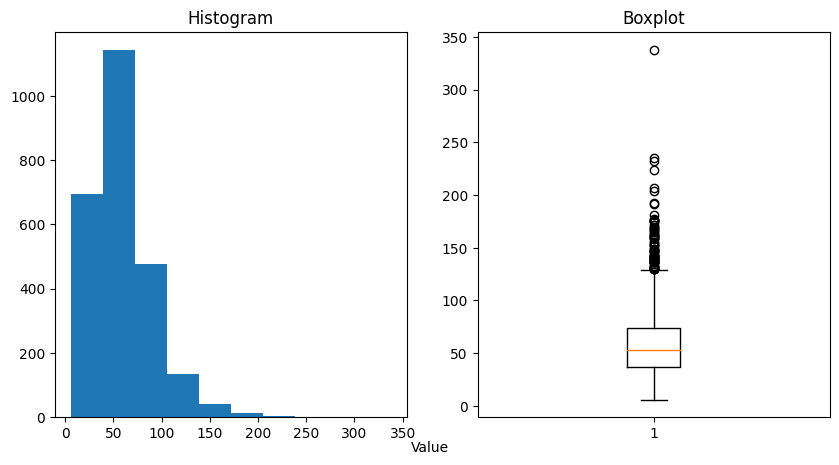

In [ ]:
import matplotlib.pyplot as plt

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot the histogram on the first axis
ax1.hist(df['word_counts'], bins=10)
ax1.set_title('Histogram')

# plot the boxplot on the second axis
ax2.boxplot(df['word_counts'])
ax2.set_title('Boxplot')

# add a common x-axis label
fig.text(0.5, 0.04, 'Value', ha='center')

# show the plot
plt.show()


In [ ]:
# Let's check some story with the smallest number of words
df[df['word_counts'] < avg - std].sort_values('word_counts', ascending=True, inplace=False)

,ID,age,gender,sent,labels,topic,tokens,clean_text,word_counts
138,28,32,F,Hire illegal immigrants for cheaper pay.,F,Migration,hire illegal immigrants for cheaper pay,hire illegal immigrant cheap pay,6
118,24,46,M,A border wall will fix it,F,Migration,a border wall will fix it,border wall fix,6
510,103,30,F,Abortion is murder and should be illegal.,F,Abortion,abortion is murder and should be illegal,abortion murder illegal,7
156,32,32,F,Euthanasia should be legal in some circumstances.,T,Euthanasia,euthanasia should be legal in some circumstances,euthanasia legal circumstance,7
756,152,26,F,People shouldn't be put down like dogs.,F,Euthanasia,people should n't be put down like dogs,people like dog,8
...,...,...,...,...,...,...,...,...,...
2070,415,28,M,Abortion is murdering an unborn child. The chi...,T,Abortion,abortion is murdering an unborn child the chil...,abortion murder unborn child child choice form...,28
2199,440,24,F,Canabis saves so many people everyday and I be...,F,Cannabis Legalization,canabis saves so many people everyday and i be...,canabis save people everyday believe completel...,28
2276,456,78,F,Suffering especially human suffering is uncons...,F,Euthanasia,suffering especially human suffering is uncons...,suffer especially human suffering unconscionab...,28
1558,312,33,M,We shouldnt let them in. They are taking our j...,F,Migration,we should nt let them in they are taking our j...,not let take job racist terrorist rapist think...,28


In [ ]:
# Explore single story:
df.loc[118,'sent']

'A border wall will fix it'

In [ ]:
# Save the preprocessed dataset
df.to_csv('preprocessed_DecOp_EN_500.csv', index = False)

# Linguistic Features Extraction:

## TEXTSTAT

TEXTSTAT is a Python package that provides a variety of text statistics, including readability scores and other metrics. Here's an example of how to use textstat to compute summary statistics for a text:

This code computes several summary statistics for the text variable:


1.   The number of sentences is computed using the sentence_count function from textstat.
2. The number of words is computed using the lexicon_count function.
3. The number of syllables is computed using the syllable_count function.
4. The average number of syllables per word is computed by dividing the total number of syllables by the total number of words.
5. The Flesch-Kincaid Grade Level is computed using the flesch_kincaid_grade function.





In [ ]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.8 MB/s eta 0:00:00


In [ ]:
import textstat

text_stats_df = pd.DataFrame()

for text in df['sent']:
  # Compute the number of sentences
  num_sentences = textstat.sentence_count(text)
  # Compute the number of words
  num_words = textstat.lexicon_count(text)
  # Compute the number of syllables
  num_syllables = textstat.syllable_count(text)
  # Compute the average number of syllables per word
  avg_syllables_per_word = num_syllables / num_words
  # Compute the Flesch-Kincaid Grade Level (focus on sentence length)
  fk_grade = textstat.flesch_kincaid_grade(text)
  # Compute the Flesch-Kincaid Grade Level (focus on syllables length)
  fk_read = textstat.flesch_reading_ease(text)

  # Create a dictionary with the computed values
  text_stats_dict = {
      'num_sentences': num_sentences,
      #'num_words': num_words,
      'num_syllables': num_syllables,
      'avg_syllables_per_word': avg_syllables_per_word,
      'fk_grade': fk_grade,
      'fk_read': fk_read
  }

  # Append the dictionary to text_stats_df as a new row
  # text_stats_df = text_stats_df.append(text_stats_dict, ignore_index=True)
  text_stats_df = pd.concat([text_stats_df, pd.DataFrame(text_stats_dict, index=[0])], ignore_index=True)


# Display the final dataset:
#text_stats_df['labels'] = list(df['labels'])
#text_stats_df['ID'] = list(df['ID'])
text_stats_df

,num_sentences,num_syllables,avg_syllables_per_word,fk_grade,fk_read
0,3,24,1.263158,2.2,90.46
1,3,66,1.941176,11.2,34.63
2,3,73,1.303571,7.0,77.87
3,3,42,1.272727,4.0,85.69
4,3,73,1.431373,7.6,71.14
...,...,...,...,...,...
2495,5,136,1.295238,7.9,75.54
2496,4,137,1.370000,10.7,63.02
2497,5,151,1.411215,9.3,66.67
2498,4,171,1.500000,13.2,51.01


## LIWC - load output

Use this code if you already have a dataset output obtained by LIWC-22 https://www.liwc.app

In [ ]:
liwc_df = pd.read_csv('/content/LIWC-22_tokenizedtext_DecOp_EN_500.csv', sep=',')
liwc_df

,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,1,19,22.98,99.00,1.00,1.00,19.0,15.79,94.74,63.16,...,0.0,0,0.00,0.00,0.0,0.0,0,0.00,0.0,0
1,1,36,41.36,13.82,22.12,20.23,36.0,38.89,77.78,61.11,...,0.0,0,5.56,0.00,0.0,0.0,0,5.56,0.0,0
2,1,61,13.44,59.57,37.69,89.90,61.0,9.84,90.16,77.05,...,0.0,0,8.20,0.00,0.0,0.0,0,8.20,0.0,0
3,1,34,29.85,99.00,4.60,66.58,34.0,14.71,94.12,73.53,...,0.0,0,2.94,0.00,0.0,0.0,0,2.94,0.0,0
4,1,53,48.72,29.60,18.63,49.04,53.0,18.87,92.45,71.70,...,0.0,0,3.77,0.00,0.0,0.0,0,3.77,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1,106,40.26,77.12,1.00,1.00,106.0,16.04,98.11,73.58,...,0.0,0,0.94,0.00,0.0,0.0,0,0.94,0.0,0
2496,1,101,14.19,1.00,33.95,1.00,101.0,20.79,96.04,80.20,...,0.0,0,0.00,0.00,0.0,0.0,0,0.00,0.0,0
2497,1,109,99.00,66.98,45.04,20.23,54.5,21.10,92.66,64.22,...,0.0,0,1.83,0.92,0.0,0.0,0,0.92,0.0,0
2498,1,114,65.22,40.06,22.93,46.76,114.0,21.93,96.49,71.05,...,0.0,0,0.00,0.00,0.0,0.0,0,0.00,0.0,0


In [ ]:
list(liwc_df.columns)

['Segment',
 'WC',
 'Analytic',
 'Clout',
 'Authentic',
 'Tone',
 'WPS',
 'BigWords',
 'Dic',
 'Linguistic',
 'function',
 'pronoun',
 'ppron',
 'i',
 'we',
 'you',
 'shehe',
 'they',
 'ipron',
 'det',
 'article',
 'number',
 'prep',
 'auxverb',
 'adverb',
 'conj',
 'negate',
 'verb',
 'adj',
 'quantity',
 'Drives',
 'affiliation',
 'achieve',
 'power',
 'Cognition',
 'allnone',
 'cogproc',
 'insight',
 'cause',
 'discrep',
 'tentat',
 'certitude',
 'differ',
 'memory',
 'Affect',
 'tone_pos',
 'tone_neg',
 'emotion',
 'emo_pos',
 'emo_neg',
 'emo_anx',
 'emo_anger',
 'emo_sad',
 'swear',
 'Social',
 'socbehav',
 'prosocial',
 'polite',
 'conflict',
 'moral',
 'comm',
 'socrefs',
 'family',
 'friend',
 'female',
 'male',
 'Culture',
 'politic',
 'ethnicity',
 'tech',
 'Lifestyle',
 'leisure',
 'home',
 'work',
 'money',
 'relig',
 'Physical',
 'health',
 'illness',
 'wellness',
 'mental',
 'substances',
 'sexual',
 'food',
 'death',
 'need',
 'want',
 'acquire',
 'lack',
 'fulfill',
 '

In [ ]:
# Select column of interest:
liwc_final = liwc_df[['Analytic',
                      'Authentic',
                      'Tone',
                        'tone_pos',
                        'tone_neg',
                      'focuspast',
                      'focuspresent',
                      'focusfuture',
                      'Cognition',   # for Cognitive Operations
                        'memory']].copy()

# Distancing
liwc_final.loc[:, 'Self-reference'] = liwc_df['i'] + liwc_df['we']
liwc_final.loc[:, 'Other-reference'] = liwc_df['shehe'] + liwc_df['they'] + liwc_df['you']

# Contextual Embedding
liwc_final.loc[:, 'Contextual Embedding'] = liwc_df['space'] + liwc_df['motion'] + liwc_df['time']

# Perceptual Processes
liwc_final.loc[:, 'Perceptual Details'] = liwc_df['attention'] + liwc_df['visual'] + liwc_df['auditory'] + liwc_df['feeling']

# Reality Monitoring
liwc_final.loc[:, 'Reality Monitoring'] = liwc_final['Perceptual Details'] + liwc_final['Contextual Embedding'] + liwc_df['Affect'] - liwc_df['Cognition']

# Add word counts and memType
#liwc_final.loc[:, 'word_counts'] = liwc_df['WC']
#liwc_final.loc[:, 'labels'] = liwc_df['labels']
#liwc_final.loc[:, 'topic'] = liwc_df['topic']
#liwc_final.loc[:, 'ID'] = liwc_df['ID']

# Display df:
liwc_final


,Analytic,Authentic,Tone,tone_pos,tone_neg,focuspast,focuspresent,focusfuture,Cognition,memory,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring
0,22.98,1.00,1.00,0.00,10.53,0.00,5.26,10.53,15.79,0.0,0.00,10.53,5.26,0.00,0.00
1,41.36,22.12,20.23,2.78,2.78,0.00,5.56,0.00,22.22,0.0,11.11,0.00,0.00,0.00,-16.66
2,13.44,37.69,89.90,4.92,0.00,0.00,4.92,0.00,18.03,0.0,3.28,3.28,3.28,0.00,-9.83
3,29.85,4.60,66.58,5.88,2.94,0.00,2.94,0.00,5.88,0.0,8.82,17.65,8.82,0.00,11.76
4,48.72,18.63,49.04,3.77,1.89,0.00,1.89,1.89,18.87,0.0,3.77,1.89,5.66,1.89,-5.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,40.26,1.00,1.00,0.94,7.55,0.00,8.49,3.77,21.70,0.0,0.94,5.66,6.60,0.94,-5.67
2496,14.19,33.95,1.00,0.99,5.94,0.00,7.92,0.00,18.81,0.0,6.93,0.99,4.95,3.96,-2.97
2497,99.00,45.04,20.23,1.83,1.83,2.75,4.59,0.00,9.17,0.0,0.92,0.00,14.68,0.00,9.18
2498,65.22,22.93,46.76,4.39,2.63,0.88,7.89,0.88,9.65,0.0,2.63,0.00,9.64,0.00,7.01


In [ ]:
liwc_final.describe()

,Analytic,Authentic,Tone,tone_pos,tone_neg,focuspast,focuspresent,focusfuture,Cognition,memory,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,40.375564,32.546688,26.601984,2.394476,3.709800,1.504828,6.020396,1.049620,18.517384,0.010904,3.421268,2.889316,8.591264,0.861784,-2.880760
std,27.215563,31.712433,31.108261,2.587217,4.000934,2.041106,3.452309,1.895741,6.695123,0.127545,3.423385,3.128573,5.475979,1.563238,10.507504
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-53.130000
25%,16.830000,4.100000,1.000000,0.000000,0.000000,0.000000,3.640000,0.000000,13.995000,0.000000,0.000000,0.000000,4.760000,0.000000,-9.680000
50%,36.670000,20.645000,20.230000,1.910000,2.860000,0.000000,5.710000,0.000000,18.255000,0.000000,2.780000,2.130000,8.000000,0.000000,-3.175000
75%,61.912500,55.790000,44.380000,3.700000,5.207500,2.470000,8.000000,1.720000,22.410000,0.000000,5.260000,4.590000,11.430000,1.455000,3.802500
max,99.000000,99.000000,99.000000,21.050000,42.860000,17.330000,25.000000,25.000000,53.130000,2.500000,24.240000,22.220000,44.440000,17.640000,42.870000


## Named Entity Recognition:

In [ ]:
# Load the .csv file obtained from the Notebook Opinion_NER_Transformer
ner_df = pd.read_csv('ner_opinions.csv')

In [ ]:
ner_df.head()

,CARDINAL,WORK_OF_ART,NORP,GPE,LAW,ORDINAL,PERCENT,PERSON,DATE,ORG,TIME,LANGUAGE,MONEY,FAC,LOC,QUANTITY,PRODUCT,EVENT
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.886792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Entity\t\tDESCRIPTION")
print("---------------------------")

for ent in list(ner_df.columns[3:]):
  print(ent+"\t\t"+spacy.explain(ent))

Entity		DESCRIPTION
---------------------------
GPE		Countries, cities, states
LAW		Named documents made into laws.
ORDINAL		"first", "second", etc.
PERCENT		Percentage, including "%"
PERSON		People, including fictional
DATE		Absolute or relative dates or periods
ORG		Companies, agencies, institutions, etc.
TIME		Times smaller than a day
LANGUAGE		Any named language
MONEY		Monetary values, including unit
FAC		Buildings, airports, highways, bridges, etc.
LOC		Non-GPE locations, mountain ranges, bodies of water
QUANTITY		Measurements, as of weight or distance
PRODUCT		Objects, vehicles, foods, etc. (not services)
EVENT		Named hurricanes, battles, wars, sports events, etc.


Group the columns representing the same construct:

**Temporal Details**: Data + Time + Event

**Spatial Details**: GPE + Lol + Faculties

**People**: Person

**Quantity Details**: Percent + Money + Quantity + Cardinal + Ordinal

**Other Details (concrete reference to smth)**: Org + Norp + Language + Work_of_art + Product + Law



In [ ]:
new_ner = pd.DataFrame([])
new_ner['Temporal details'] = ner_df['DATE'] + ner_df['TIME'] + ner_df['EVENT']
new_ner['Spatial details'] = ner_df['GPE'] + ner_df['LOC'] + ner_df['FAC']
new_ner['People'] = ner_df['PERSON']
new_ner['Quantity details'] = ner_df['PERCENT'] + ner_df['MONEY'] + ner_df['QUANTITY'] + ner_df['CARDINAL'] + ner_df['ORDINAL']
# new_ner['Others'] = ner_df['ORG'] + ner_df['NORP'] + ner_df['LANGUAGE'] + ner_df['WORK_OF_ART'] + ner_df['PRODUCT']

new_ner.head()

,Temporal details,Spatial details,People,Quantity details
0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,1.886792


In [ ]:
new_ner.shape

(2500, 5)

In [ ]:
new_ner.isna().sum()

Temporal     0
Spatial      0
People       0
Numerical    0
Others       0
dtype: int64

In [ ]:
new_ner.describe()

,Temporal,Spatial,People,Numerical,Others
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.147737,0.246686,0.053057,0.231644,0.252162
std,0.590224,0.818697,0.670479,0.715641,0.804993
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.142857,9.090909,26.666667,7.142857,7.407407


## Concreteness

In [ ]:
# Load Brysbaert dataset
concr_df = pd.read_excel('/content/Brysbaert concreteness scoring.xlsx')
concr_df.head()

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX
0,a,0,1.46,1.14,2,30,0.933333,1041179
1,aardvark,0,4.68,0.86,0,28,1.000000,21
2,aback,0,1.65,1.07,4,27,0.851852,15
3,abacus,0,4.52,1.12,2,29,0.931034,12
4,abandon,0,2.54,1.45,1,27,0.962963,413


In [ ]:
concr_df.shape

(39954, 8)

In [ ]:
def get_avg_concr_score(text):
    # Tokenize the opinion and convert to set
    tokens = set(text.split())

    # Get the concreteness score for each token
    matches = concr_df['Word'].str.lower().isin(tokens)
    scores = concr_df.loc[matches, 'Conc.M'].values

    # Compute the average score
    avg_score = scores.mean() if len(scores) > 0 else 0

    return avg_score

In [ ]:
df['concr_score'] = df.loc[:,'clean_text'].apply(get_avg_concr_score)
df

,ID,age,gender,sent,labels,topic,tokens,clean_text,word_counts,concr_score
0,1,28,F,Abortion should be banned! People are killing ...,F,Abortion,abortion should be banned people are killing b...,abortion ban people kill baby sex live consequ...,19,3.726250
1,1,28,F,I'm assuming we're talking about animals... eu...,T,Euthanasia,i 'm assuming we 're talking about animals eut...,assume talk animal euthanasia make sad underst...,36,2.709286
2,1,28,F,I think gay marriage is just a normal as strai...,T,Gay Marriage,i think gay marriage is just a normal as strai...,think gay marriage normal straight marriage af...,61,2.550000
3,1,28,F,We need to keep them out of the country. They ...,F,Migration,we need to keep them out of the country they a...,need country dangerous bring drug steal job be...,34,3.163333
4,1,28,F,I think it should be legalized and regulated l...,T,Cannabis Legalization,i think it should be legalized and regulated l...,think legalize regulate like alcohol able driv...,53,3.071250
...,...,...,...,...,...,...,...,...,...,...
2495,500,25,M,I believe that abortion is a woman's right. A ...,T,Abortion,i believe that abortion is a woman 's right a ...,believe abortion woman right woman control bod...,106,3.108400
2496,500,25,M,My opinion on Euthanasia is that it should not...,F,Euthanasia,my opinion on euthanasia is that it should not...,opinion euthanasia legal united states agree n...,101,2.649615
2497,500,25,M,Gay marriage is an atrocity to society. How ca...,F,Gay Marriage,gay marriage is an atrocity to society how can...,gay marriage atrocity society country united s...,109,2.882812
2498,500,25,M,I think that migrants should come to the Unite...,T,Migration,i think that migrants should come to the unite...,think migrant come united states legally under...,114,3.140541


In [ ]:
df.head()

,ID,age,gender,sent,labels,topic,tokens,clean_text,word_counts,concr_score
0,1,28,F,Abortion should be banned! People are killing ...,F,Abortion,abortion should be banned people are killing b...,abortion ban people kill baby sex live consequ...,19,3.726250
1,1,28,F,I'm assuming we're talking about animals... eu...,T,Euthanasia,i 'm assuming we 're talking about animals eut...,assume talk animal euthanasia make sad underst...,36,2.709286
2,1,28,F,I think gay marriage is just a normal as strai...,T,Gay Marriage,i think gay marriage is just a normal as strai...,think gay marriage normal straight marriage af...,61,2.550000
3,1,28,F,We need to keep them out of the country. They ...,F,Migration,we need to keep them out of the country they a...,need country dangerous bring drug steal job be...,34,3.163333
4,1,28,F,I think it should be legalized and regulated l...,T,Cannabis Legalization,i think it should be legalized and regulated l...,think legalize regulate like alcohol able driv...,53,3.071250


## Jaccard Index

The Jaccard index is a measure of similarity between two sets. In the context of text analysis, we can use the Jaccard index to compare the vocabulary used in two texts. Here we compute the general Jaccard index between 'imagined' and 'recalled' stories.

We convert each group to a set of unique words using the split and explode methods of pandas. The split method splits each text into a list of words, and the explode method creates a new row for each word in the resulting list. This allows us to create a set of all the unique words in both columns.

We then compute the intersection and union of the two sets returning the Jaccard index which varies from 0 (completely different vocabulary among the two sets) and 1 (completly same vocabulary among the two sets).

In [ ]:
df_grouped = df.groupby(['topic','labels'])['clean_text'].agg(' '.join).reset_index()
df_grouped

,topic,labels,clean_text
0,Abortion,F,abortion ban people kill baby sex live consequ...
1,Abortion,T,consider pro choice abortion think choice stro...
2,Cannabis Legalization,F,cannabi legalize research prove extensive rese...
3,Cannabis Legalization,T,think legalize regulate like alcohol able driv...
4,Euthanasia,F,believe right play god circumstance matter sit...
5,Euthanasia,T,assume talk animal euthanasia make sad underst...
6,Gay Marriage,F,believe gay marriage completely wrong go relig...
7,Gay Marriage,T,think gay marriage normal straight marriage af...
8,Migration,F,need country dangerous bring drug steal job be...
9,Migration,T,think live nation form immigrant america know ...


In [ ]:
df_grouped_h = df_grouped[df_grouped['labels'] == 'T'].reset_index().drop(['labels','index'], axis=1)
df_grouped_d = df_grouped[df_grouped['labels'] == 'F'].reset_index().drop(['labels','index'], axis=1)

In [ ]:
df_grouped_d

,topic,clean_text
0,Abortion,abortion ban people kill baby sex live consequ...
1,Cannabis Legalization,cannabi legalize research prove extensive rese...
2,Euthanasia,believe right play god circumstance matter sit...
3,Gay Marriage,believe gay marriage completely wrong go relig...
4,Migration,need country dangerous bring drug steal job be...


In [ ]:
jaccard_index = []

for text1, text2 in zip(df_grouped_h['clean_text'], df_grouped_d['clean_text']):
  # Convert each column to sets of unique words
  set1 = set(text1.split())
  set2 = set(text2.split())

  # Compute the intersection and union of the two sets
  intersection = set1.intersection(set2)
  union = set1.union(set2)

  # Compute the Jaccard index
  jaccard = len(intersection) / len(union)
  jaccard_index.append(jaccard)

jaccard_index = np.array(jaccard_index)

In [ ]:
for i, topic in enumerate(df_grouped_h['topic']):
  print(f"jaccard_index in {topic}: {jaccard_index[i]}")

print(f"jaccard_index in All Opinions: {jaccard_index.mean()}")

jaccard_index in Abortion: 0.361714621256606
jaccard_index in Cannabis Legalization: 0.3613835828600929
jaccard_index in Euthanasia: 0.3437146092865232
jaccard_index in Gay Marriage: 0.33647058823529413
jaccard_index in Migration: 0.3401147626499739
jaccard_index in All Opinions: 0.34867963285769804


# Data Analysis:

In [ ]:
# Merge the datasets containing the results
ID = pd.Series(df['ID']).reset_index().drop('index', axis = 1)
labels = pd.Series(df['labels']).reset_index().drop('index', axis = 1)
word_counts = pd.Series(df['word_counts']).reset_index().drop('index', axis = 1)
concr_score = df['concr_score']

scoring_df = pd.concat([ID,labels, word_counts, text_stats_df, liwc_final, concr_score, new_ner] , axis=1)
scoring_df

,ID,labels,word_counts,num_sentences,num_syllables,avg_syllables_per_word,fk_grade,fk_read,Analytic,Authentic,...,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring,concr_score,Temporal details,Spatial details,People,Quantity details
0,1,F,19,3,24,1.263158,2.2,90.46,22.98,1.00,...,0.00,10.53,5.26,0.00,0.00,3.726250,0.0,0.000000,0.0,0.000000
1,1,T,36,3,66,1.941176,11.2,34.63,41.36,22.12,...,11.11,0.00,0.00,0.00,-16.66,2.709286,0.0,0.000000,0.0,0.000000
2,1,T,61,3,73,1.303571,7.0,77.87,13.44,37.69,...,3.28,3.28,3.28,0.00,-9.83,2.550000,0.0,0.000000,0.0,0.000000
3,1,F,34,3,42,1.272727,4.0,85.69,29.85,4.60,...,8.82,17.65,8.82,0.00,11.76,3.163333,0.0,0.000000,0.0,0.000000
4,1,T,53,3,73,1.431373,7.6,71.14,48.72,18.63,...,3.77,1.89,5.66,1.89,-5.66,3.071250,0.0,0.000000,0.0,1.886792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,500,T,106,5,136,1.295238,7.9,75.54,40.26,1.00,...,0.94,5.66,6.60,0.94,-5.67,3.108400,0.0,0.000000,0.0,0.000000
2496,500,F,101,4,137,1.370000,10.7,63.02,14.19,33.95,...,6.93,0.99,4.95,3.96,-2.97,2.649615,0.0,1.980198,0.0,0.000000
2497,500,F,109,5,151,1.411215,9.3,66.67,99.00,45.04,...,0.92,0.00,14.68,0.00,9.18,2.882812,0.0,0.917431,0.0,0.000000
2498,500,T,114,4,171,1.500000,13.2,51.01,65.22,22.93,...,2.63,0.00,9.64,0.00,7.01,3.140541,0.0,2.631579,0.0,0.000000


In [ ]:
# Save the output dataset with the linguistic features
scoring_df.to_csv('Opinion_lingfeat.csv', index = False)

In [ ]:
scoring_df_grouped = scoring_df.groupby(['ID', 'labels']).mean().reset_index()
scoring_df_grouped

,ID,labels,word_counts,num_sentences,num_syllables,avg_syllables_per_word,fk_grade,fk_read,Analytic,Authentic,...,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring,concr_score,Temporal details,Spatial details,People,Quantity details
0,1,F,26.5,3.000000,33.000000,1.267943,3.100000,88.075000,26.415000,2.800000,...,4.410000,14.090000,7.040000,0.000000,5.880000,3.444792,0.000000,0.000000,0.0,0.000000
1,1,T,50.0,3.000000,70.666667,1.558707,8.600000,61.213333,34.506667,26.146667,...,6.053333,1.723333,2.980000,0.630000,-10.716667,2.776845,0.000000,0.000000,0.0,0.628931
2,2,F,50.0,4.000000,61.000000,1.241026,4.000000,88.500000,52.990000,37.400000,...,8.305000,3.845000,9.225000,0.000000,-0.930000,3.166149,0.000000,0.000000,0.0,0.000000
3,2,T,32.0,4.000000,46.000000,1.482226,4.733333,74.940000,53.303333,31.560000,...,5.313333,0.000000,7.400000,3.126667,6.923333,2.855222,0.000000,0.000000,0.0,0.900901
4,3,F,59.5,4.000000,79.000000,1.366277,6.000000,77.860000,34.410000,12.785000,...,4.165000,2.600000,9.490000,0.000000,-1.165000,2.938070,0.000000,0.909091,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,498,T,82.5,4.000000,104.000000,1.270439,7.750000,78.705000,27.410000,74.795000,...,9.715000,5.970000,10.295000,0.580000,-7.970000,2.751088,0.000000,0.632911,0.0,0.000000
996,499,F,67.0,4.666667,90.000000,1.365103,6.100000,76.700000,47.510000,2.113333,...,2.186667,3.973333,5.220000,0.423333,-4.633333,2.972622,0.555556,0.000000,0.0,0.000000
997,499,T,77.0,4.500000,109.500000,1.459402,8.100000,67.115000,84.250000,16.535000,...,1.900000,0.665000,10.365000,2.530000,12.395000,2.921843,0.000000,0.000000,0.0,1.333333
998,500,F,112.0,5.333333,156.000000,1.403262,9.333333,66.606667,61.173333,41.410000,...,3.146667,1.653333,11.036667,1.850000,3.386667,2.914399,0.000000,1.230427,0.0,0.264550


In [ ]:
scoring_df_grouped.iloc[:,20:30].describe()


,Contextual Embedding,Perceptual Details,Reality Monitoring,concr_score,Temporal details,Spatial details,People,Quantity details
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.623388,0.862068,-2.819910,2.931027,0.142077,0.251909,0.051835,0.232351
std,3.414500,1.067303,7.369874,0.195626,0.375732,0.541986,0.378417,0.461662
min,0.000000,0.000000,-27.870000,2.230208,0.000000,0.000000,0.000000,0.000000
25%,6.253750,0.000000,-7.742500,2.806122,0.000000,0.000000,0.000000,0.000000
50%,8.457500,0.608333,-2.570000,2.923181,0.000000,0.000000,0.000000,0.000000
75%,10.861250,1.290833,1.817500,3.048309,0.000000,0.335034,0.000000,0.312261
max,24.220000,8.780000,28.580000,3.577094,3.571429,4.166667,8.888889,3.571429


In [ ]:
list(scoring_df_grouped.columns)

['ID',
 'labels',
 'word_counts',
 'num_sentences',
 'num_syllables',
 'avg_syllables_per_word',
 'fk_grade',
 'fk_read',
 'Analytic',
 'Authentic',
 'Tone',
 'tone_pos',
 'tone_neg',
 'focuspast',
 'focuspresent',
 'focusfuture',
 'Cognition',
 'memory',
 'Self-reference',
 'Other-reference',
 'Contextual Embedding',
 'Perceptual Details',
 'Reality Monitoring',
 'concr_score',
 'Temporal details',
 'Spatial details',
 'People',
 'Quantity details']

In [ ]:
scoring_df_grouped.to_csv('scoring_df_grouped-opinions.csv', index = False)

In [ ]:
# splitting the dataset in two groups
scoring_df_h = scoring_df_grouped[scoring_df_grouped['labels']=='T'].reset_index().drop(['labels','ID','index'], axis=1)
scoring_df_d = scoring_df_grouped[scoring_df_grouped['labels']=='F'].reset_index().drop(['labels','ID','index'], axis=1)

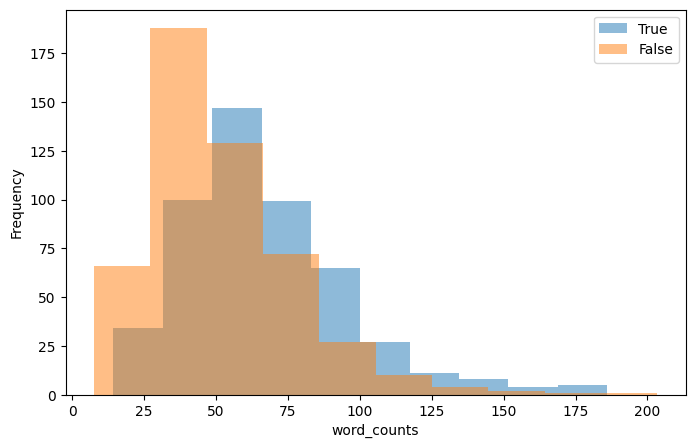

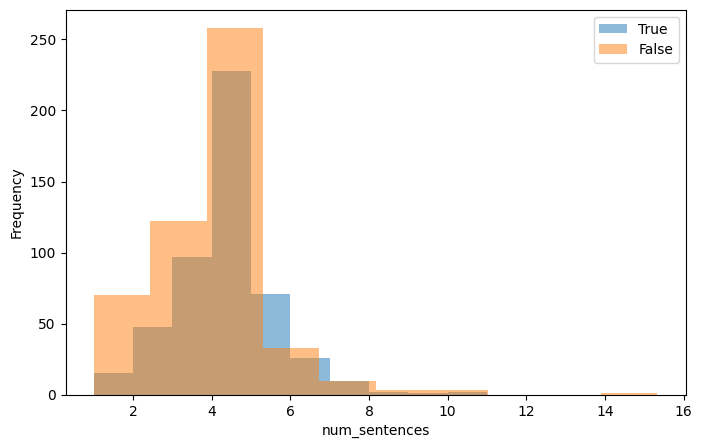

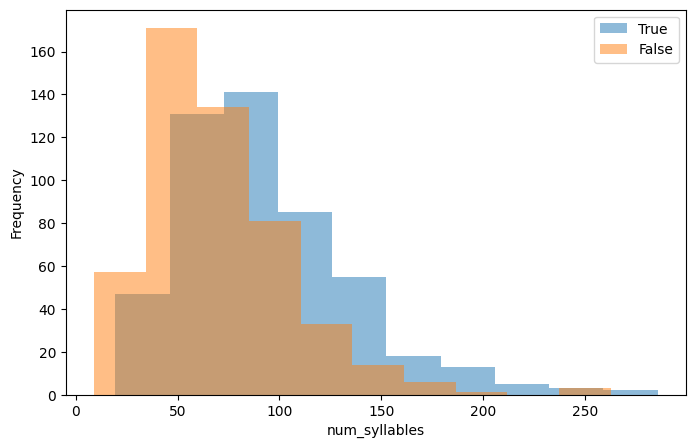

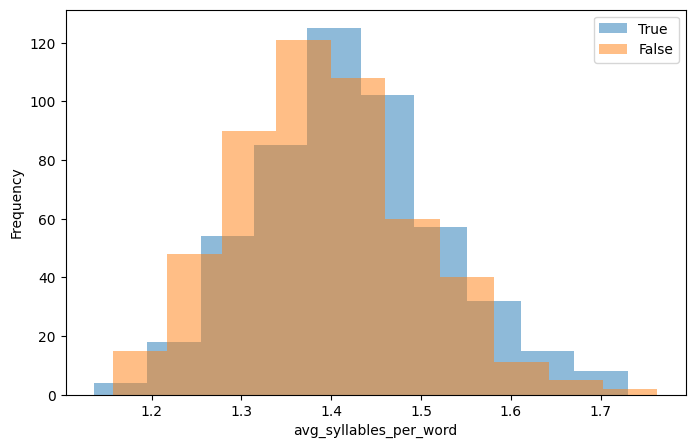

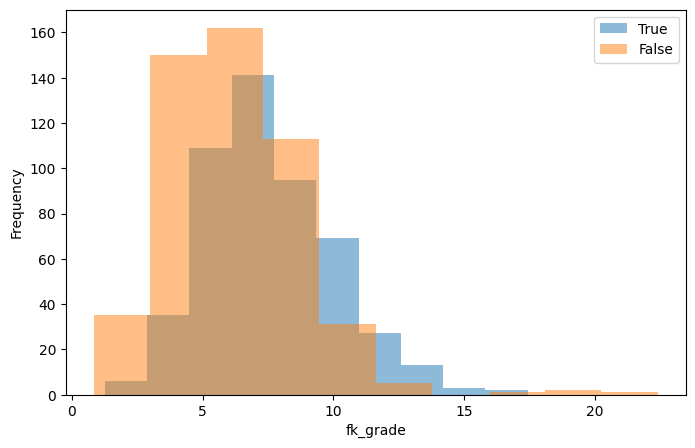

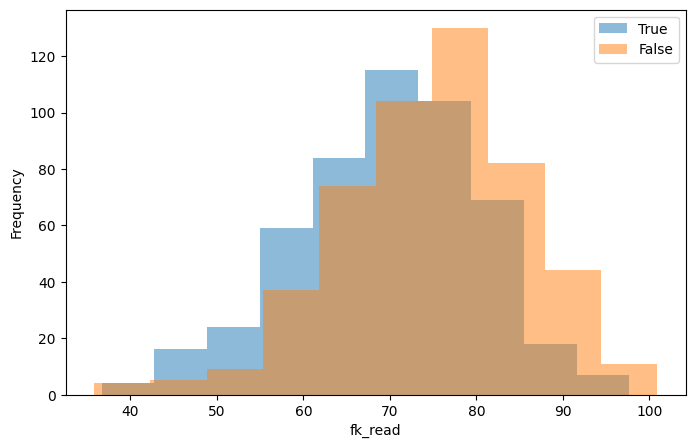

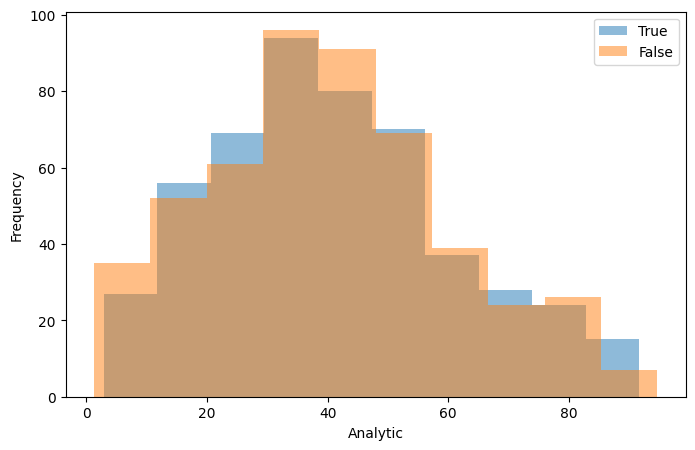

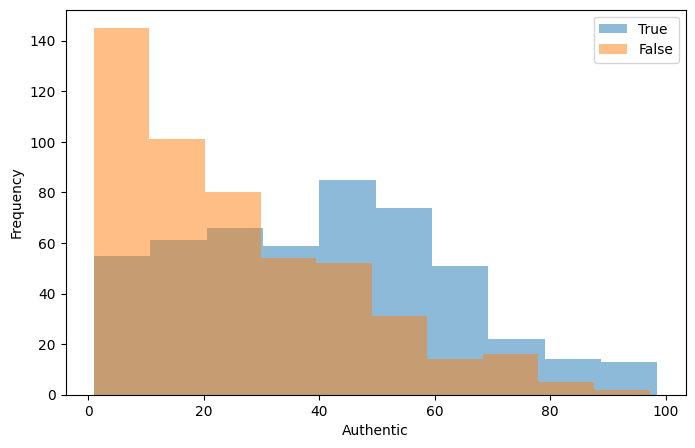

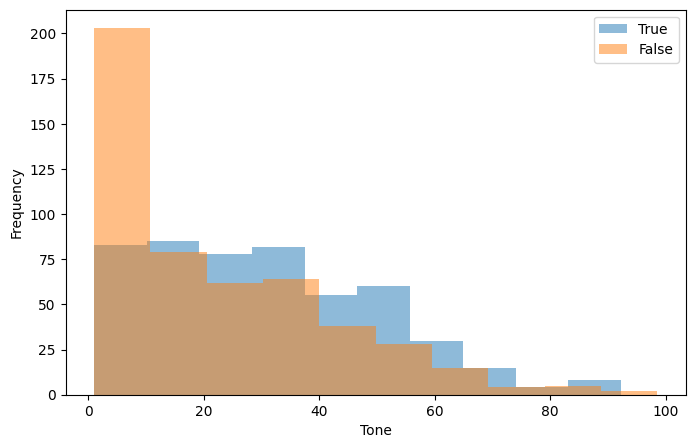

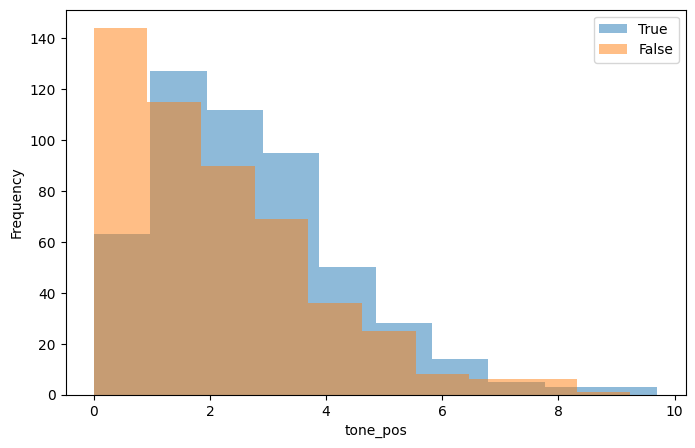

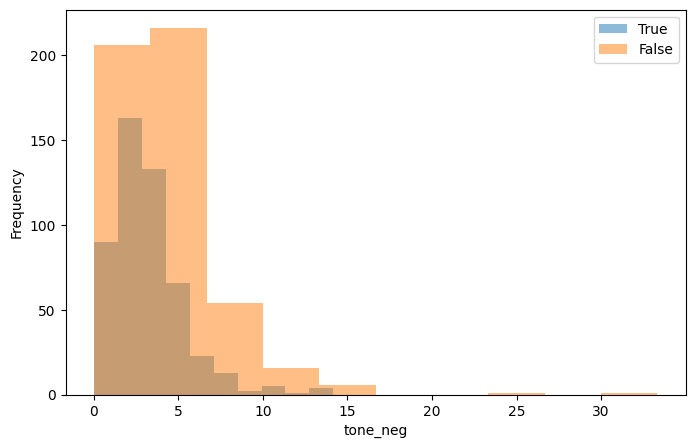

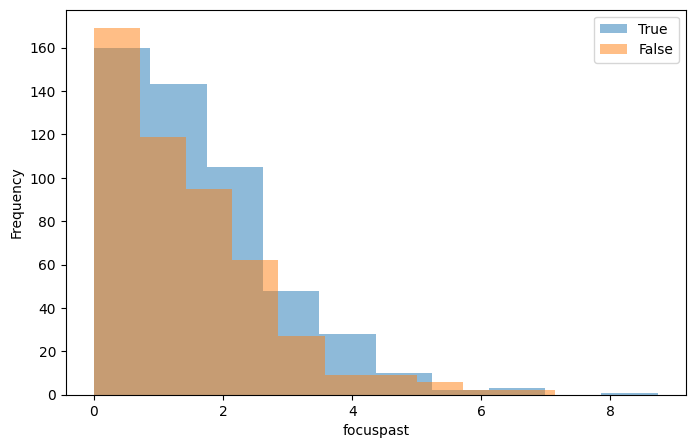

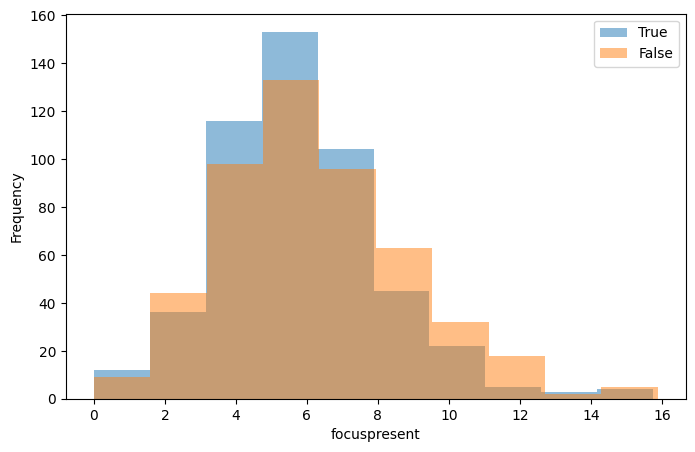

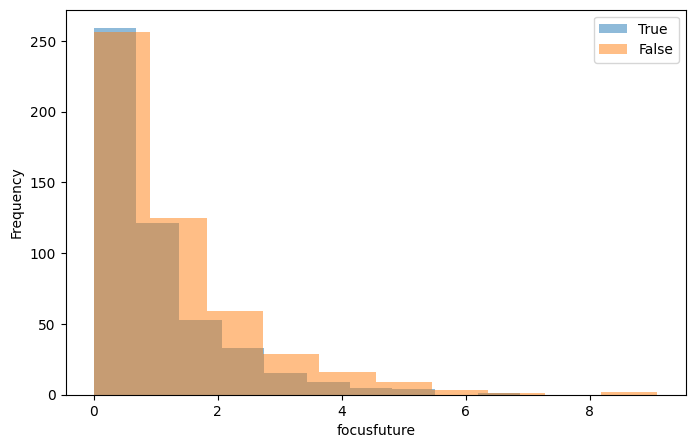

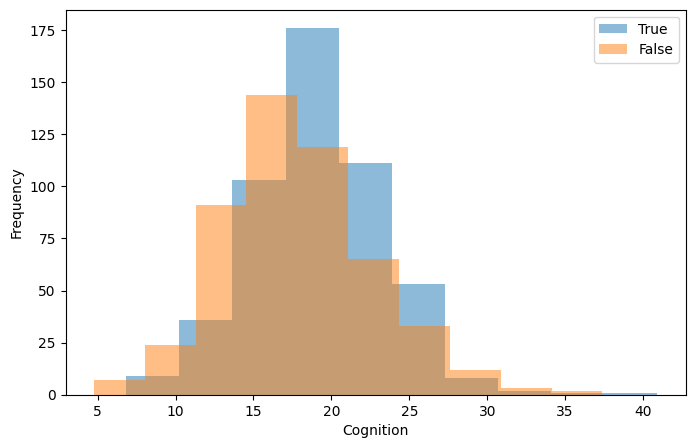

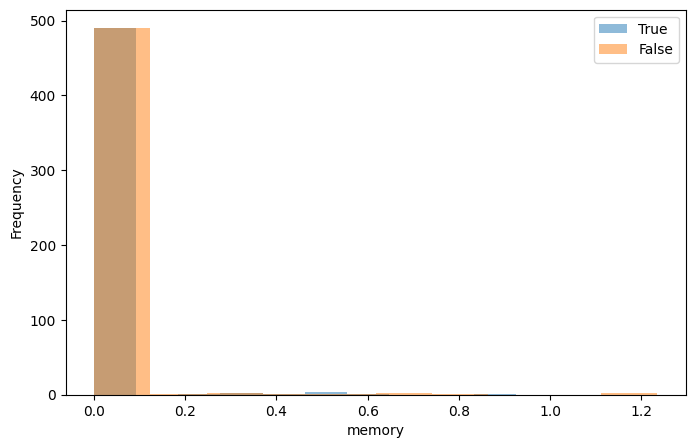

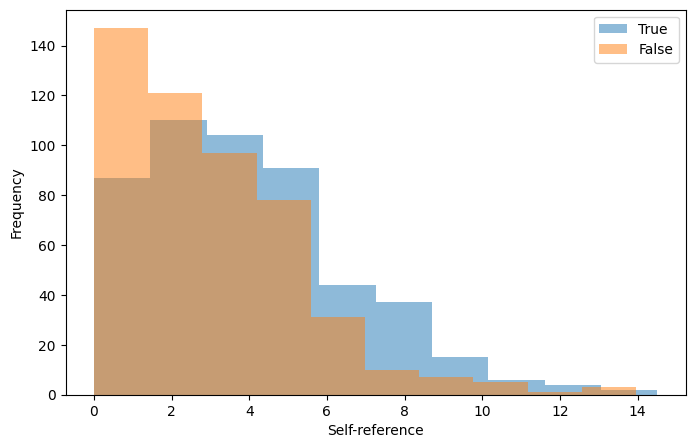

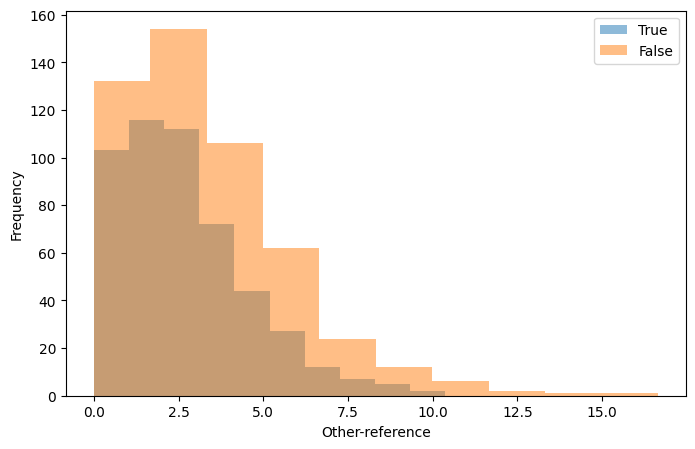

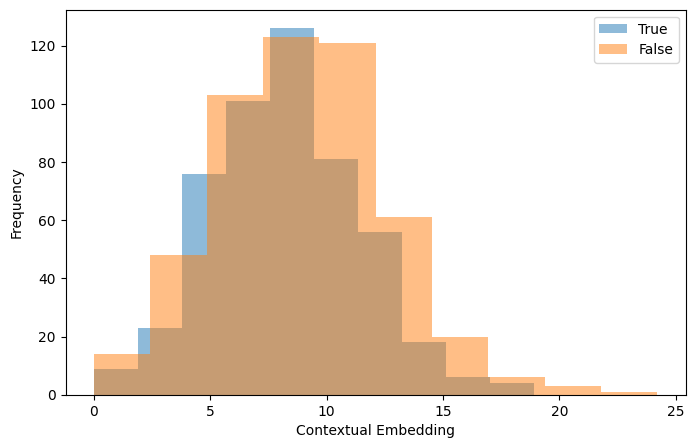

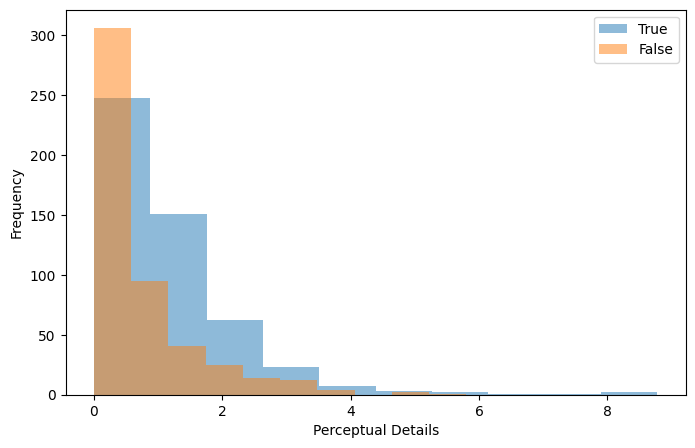

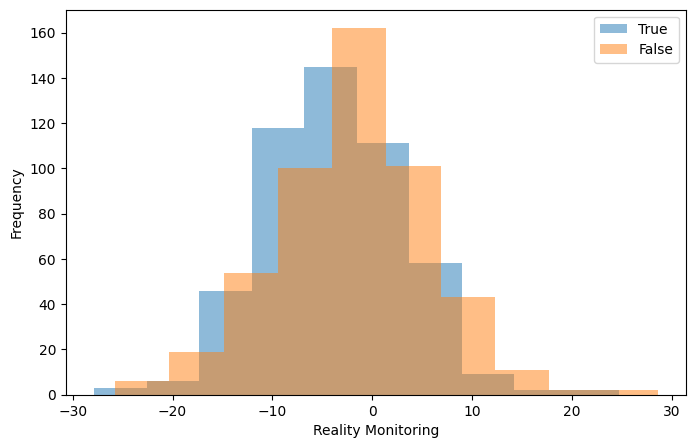

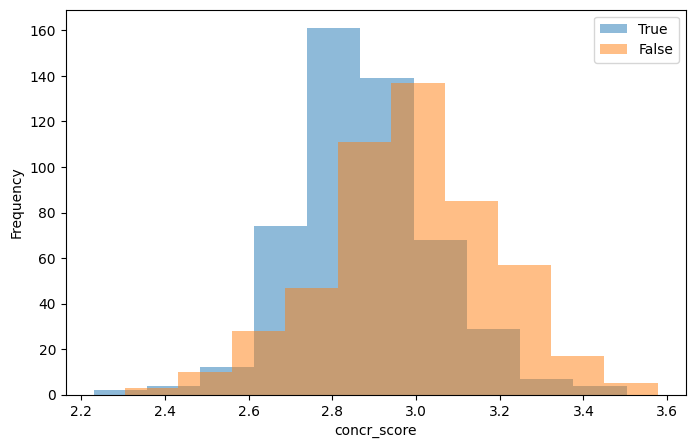

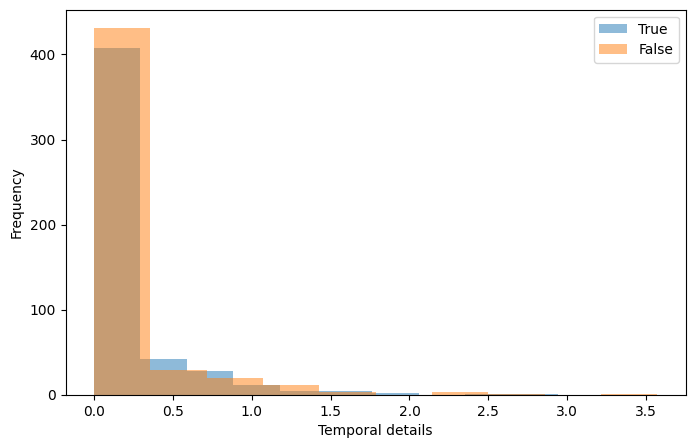

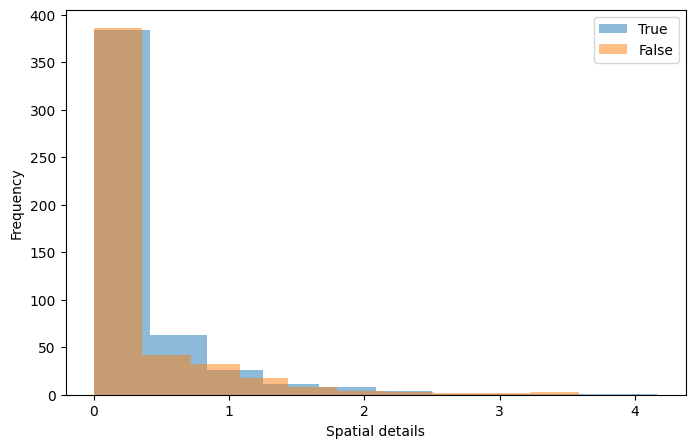

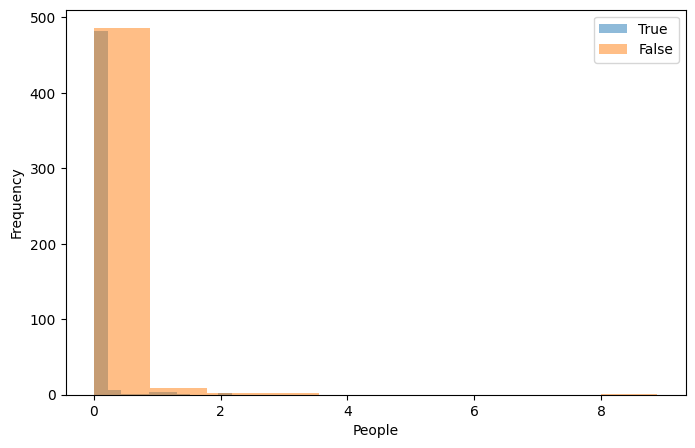

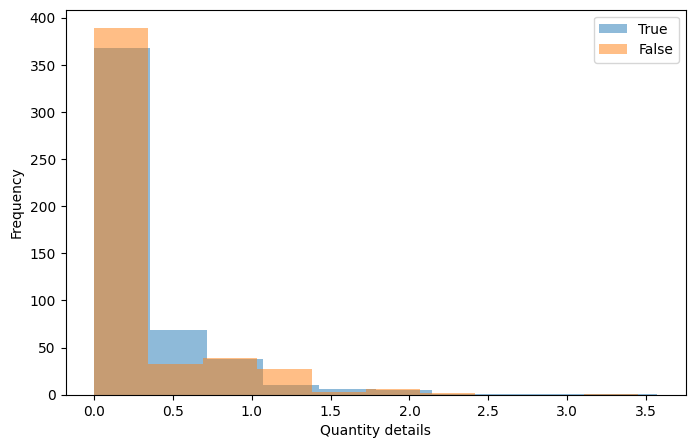

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms
for score in scoring_df_h:
    # Plot histogram for score in scoring_df_h
    scoring_df_h[score].plot.hist(alpha=0.5, figsize=(8, 5), bins=10, label = 'True')

    # Plot histogram for score in scoring_df_d
    scoring_df_d[score].plot.hist(alpha=0.5, figsize=(8, 5), bins=10, label = 'False')

    # Add labels to variables
    plt.xlabel(score)
    plt.ylabel('Frequency')
    plt.legend()

    # Show plot
    plt.show()


Boxplot

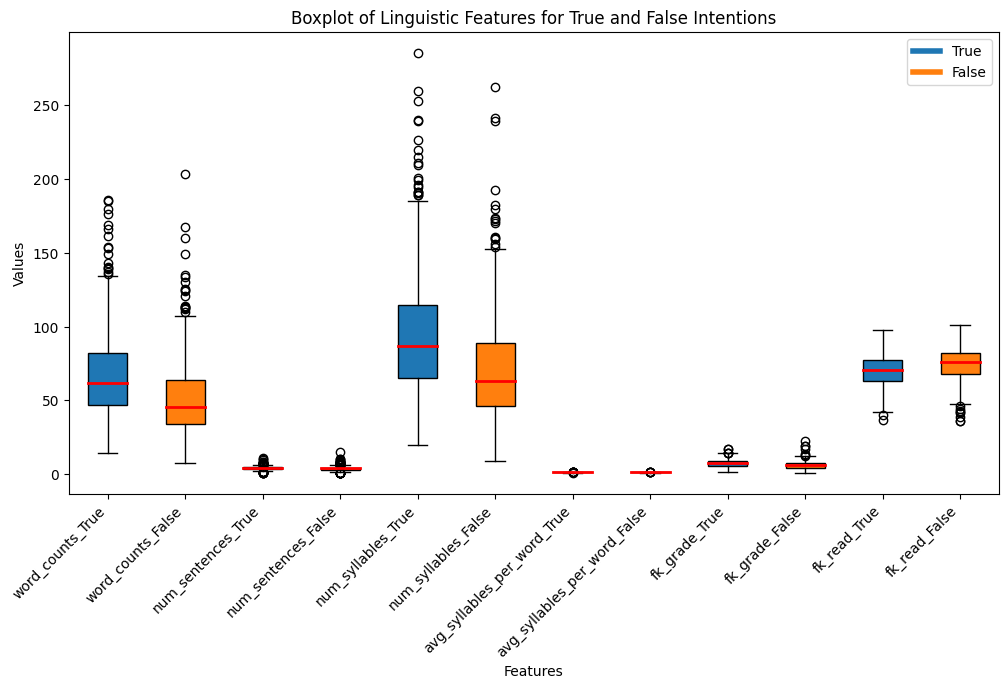

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns = scoring_df.iloc[:,2:8].columns

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create lists for boxplot data, labels, and colors
boxplot_data = []
boxplot_labels = []
colors = []

# Prepare the data for the boxplot
for column in columns:
    boxplot_data.extend([scoring_df_h[column], scoring_df_d[column]])
    boxplot_labels.extend([f"{column}_True", f"{column}_False"])
    colors.extend(['C0', 'C1'])

# Create the boxplot using Matplotlib
bp = ax.boxplot(boxplot_data, patch_artist=True)

# Set colors and labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change the color of median lines to red
for median in bp['medians']:
    median.set(color='red', linewidth=2)

ax.set_xticklabels(boxplot_labels, rotation=45, ha="right")
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Linguistic Features for True and False Intentions')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='True'),
                   Line2D([0], [0], color='C1', lw=4, label='False')]
ax.legend(handles=legend_elements)

# Show the plot
plt.show()


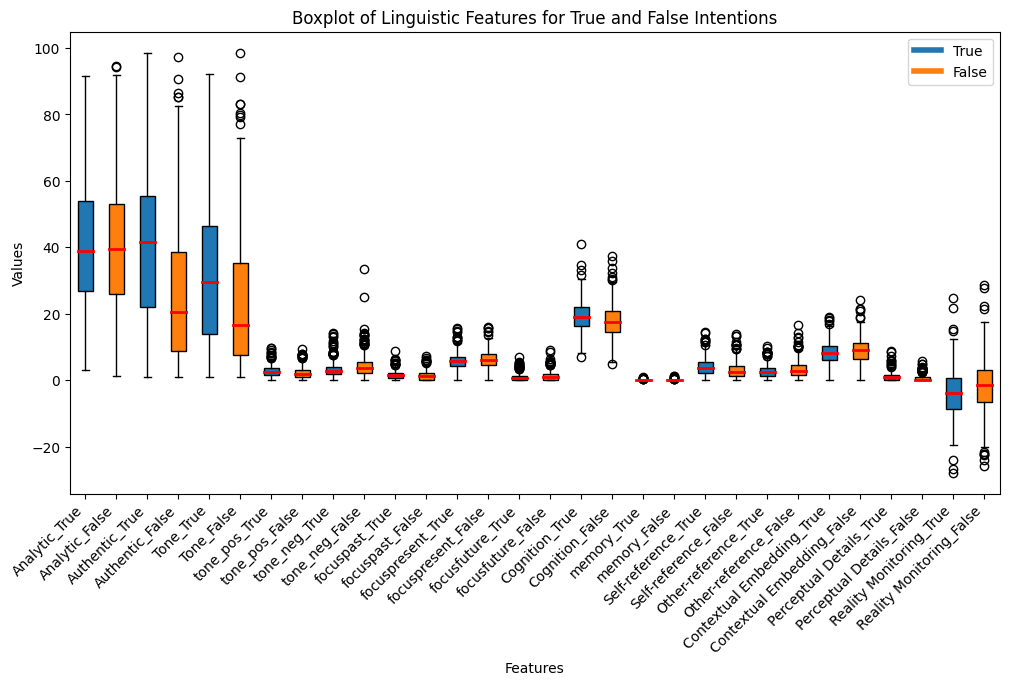

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns = scoring_df.iloc[:,8:-5].columns

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create lists for boxplot data, labels, and colors
boxplot_data = []
boxplot_labels = []
colors = []

# Prepare the data for the boxplot
for column in columns:
    boxplot_data.extend([scoring_df_h[column], scoring_df_d[column]])
    boxplot_labels.extend([f"{column}_True", f"{column}_False"])
    colors.extend(['C0', 'C1'])

# Create the boxplot using Matplotlib
bp = ax.boxplot(boxplot_data, patch_artist=True)

# Set colors and labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change the color of median lines to red
for median in bp['medians']:
    median.set(color='red', linewidth=2)

ax.set_xticklabels(boxplot_labels, rotation=45, ha="right")
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Linguistic Features for True and False Intentions')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='True'),
                   Line2D([0], [0], color='C1', lw=4, label='False')]
ax.legend(handles=legend_elements)

# Show the plot
plt.show()


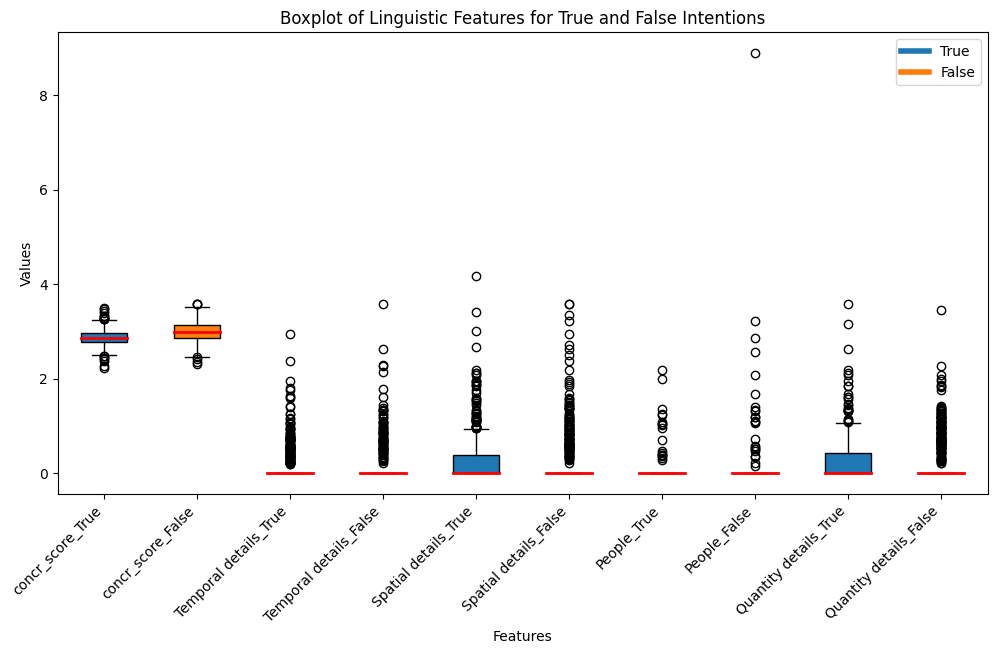

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns = scoring_df.iloc[:,-5:].columns

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create lists for boxplot data, labels, and colors
boxplot_data = []
boxplot_labels = []
colors = []

# Prepare the data for the boxplot
for column in columns:
    boxplot_data.extend([scoring_df_h[column], scoring_df_d[column]])
    boxplot_labels.extend([f"{column}_True", f"{column}_False"])
    colors.extend(['C0', 'C1'])

# Create the boxplot using Matplotlib
bp = ax.boxplot(boxplot_data, patch_artist=True)

# Set colors and labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change the color of median lines to red
for median in bp['medians']:
    median.set(color='red', linewidth=2)

ax.set_xticklabels(boxplot_labels, rotation=45, ha="right")
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Linguistic Features for True and False Intentions')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='True'),
                   Line2D([0], [0], color='C1', lw=4, label='False')]
ax.legend(handles=legend_elements)

# Show the plot
plt.show()


In [ ]:
# Computing indipendent permutation tests:

def statistic(x, y, axis):
  return np.mean(x, axis=axis) - np.mean(y, axis=axis)


stats = []
p_values = []
cles_scores = []

for col in scoring_df_h.columns:
    # stats and p-value:
    res = permutation_test((scoring_df_h[col], scoring_df_d[col]), statistic, permutation_type='samples', vectorized=True, n_resamples=10000,)
    stats.append(res.statistic)
    p_values.append(res.pvalue)
    # effect size:
    cles = pg.compute_effsize(scoring_df_h[col], scoring_df_d[col], eftype='CLES')
    cles_scores.append(cles)

# perform multiple comparisons correction using Bonferroni method
null_h_rej, corrected_p_values, _, _ = multipletests(p_values, alpha = 0.05, method='holm')

# save results in a dataframe
perm_df = pd.DataFrame({"feature": scoring_df_h.columns, "stat": stats, "p_value": p_values, "corrected_p_value": corrected_p_values, "effect_size":cles_scores, "null_h_rejected": null_h_rej})
perm_df["significance"] = ['*' if p == True else '-' for p in perm_df['null_h_rejected']]

# print all comparisons
perm_df.sort_values(["null_h_rejected","effect_size"], ascending=False, inplace=True)
perm_df

,feature,stat,p_value,corrected_p_value,effect_size,null_h_rejected,significance
7,Authentic,14.984160,0.000200,0.005199,0.694754,True,*
2,num_syllables,23.181667,0.000200,0.005199,0.683294,True,*
0,word_counts,15.507667,0.000200,0.005199,0.675388,True,*
4,fk_grade,1.395133,0.000200,0.005199,0.666456,True,*
19,Perceptual Details,0.468570,0.000200,0.005199,0.653398,True,*
8,Tone,8.191470,0.000200,0.005199,0.626874,True,*
16,Self-reference,1.051763,0.000200,0.005199,0.620004,True,*
9,tone_pos,0.633447,0.000200,0.005199,0.617604,True,*
14,Cognition,1.200807,0.000200,0.005199,0.586856,True,*
3,avg_syllables_per_word,0.027227,0.000200,0.005199,0.576730,True,*


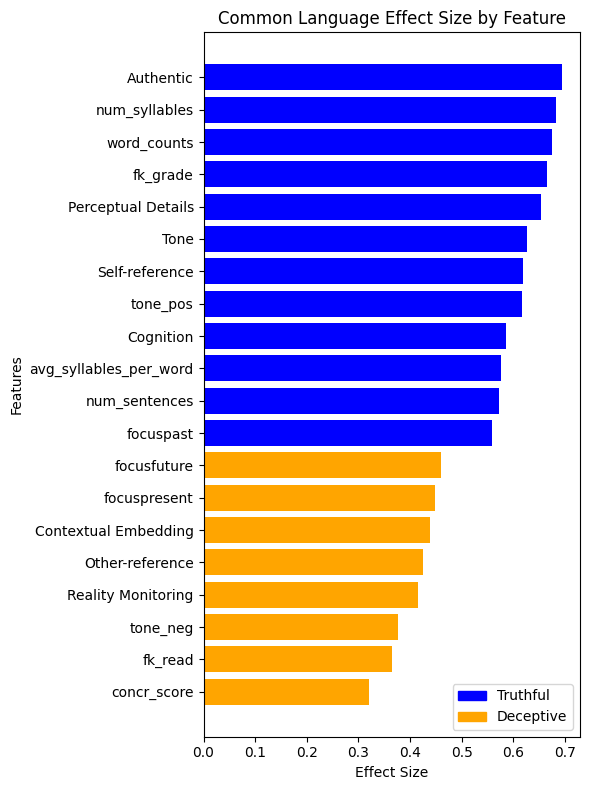

In [ ]:
import matplotlib.pyplot as plt

# Select only significant features
perm_df_selected = perm_df.loc[perm_df['null_h_rejected'] == True, :]

# Sort the dataframe by effect size in descending order
perm_df_sorted = perm_df_selected.sort_values("effect_size", ascending=True)

# Create a horizontal bar chart of effect size with an increased figure size
fig, ax = plt.subplots(figsize=(6, 8))  # Adjust the size (width, height) as needed

# Define colors based on the stat value
colors = ['blue' if stat > 0 else 'orange' for stat in perm_df_sorted['stat']]

# Plot the bars
bars = ax.barh(perm_df_sorted['feature'], perm_df_sorted['effect_size'], color=colors)

# Add legend
t_patch = plt.Rectangle((0, 0), 0, 0, color='blue', label='Truthful')
f_patch = plt.Rectangle((0, 0), 0, 0, color='orange', label='Deceptive')
plt.legend(handles=[t_patch, f_patch])

# Set labels
ax.set_xlabel('Effect Size')
ax.set_ylabel('Features')
ax.set_title('Common Language Effect Size by Feature')

# Show the plot
plt.tight_layout()
plt.show()
